Download and preprocess dataset skripsi

In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from numpy import array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/preprocessed_dataset_caption_skripsi.txt")
df

,image,caption
0,gl_1.jpg,overcoming the challenge of a deep roadside di...
1,gl_1.jpg,careful there is a ditch in side of a road.
2,gl_1.jpg,taking the leap conquering the hurdle of a tre...
3,gl_1.jpg,careful navigating through the obstacle of a d...
4,gl_2.jpg,obstacle on side of a street there is deep ca...
...,...,...
15195,gl_3799.jpg,stay vigilant while entering the traffic light...
15196,gl_3800.jpg,exercise caution as there are multiple motorcy...
15197,gl_3800.jpg,stay alert for the presence of numerous motorc...
15198,gl_3800.jpg,exercise caution due to the high number of mot...


In [ ]:
# $ conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-pjyl0vmo
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-pjyl0vmo
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=ce4030f9a860e83fd3163f462583e4959daa300c4e36d3ebd04ec42edebba563
  Stored in directory: /tmp/pip-ephem-wheel-cache-cbtcoicm/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.9 MB/s eta 0:00:00


In [ ]:
import torch
import skimage.io as io
import clip
from PIL import Image
import pickle
import json
import os
from tqdm import tqdm
import argparse

In [ ]:

import IPython.display
from IPython.display import Markdown, display
import ipywidgets as widgets

In [ ]:
def parse(clip_model_type: str):
    device = torch.device('cuda:0')
    clip_model_name = clip_model_type.replace('/', '_')
    out_path = f"./dataskripsi_{clip_model_name}_train.pkl"
    clip_model, preprocess = clip.load(clip_model_type, device=device, jit=False)
    all_embeddings = []
    all_captions = []
    for i in tqdm(range(len(df))):
        d=df.iloc[i]
        img_id = d["image"]
        filename = f"/content/drive/MyDrive/Dataset SKRIPSI/Resize/{img_id}"
        image = Image.open(filename).convert("RGB")
        image = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            prefix = clip_model.encode_image(image).cpu()
        d["clip_embedding"] = i
        all_embeddings.append(prefix)
        all_captions.append(d)
        if (i + 1) % 10000 == 0:
            with open(out_path, 'wb') as f:
                pickle.dump({"clip_embedding": torch.cat(all_embeddings, dim=0), "captions": all_captions}, f)

    with open(out_path, 'wb') as f:
        pickle.dump({"clip_embedding": torch.cat(all_embeddings, dim=0), "captions": all_captions}, f)

    print('Done')
    print("%0d embeddings saved " % len(all_embeddings))
    return 0


In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
parse('RN50x4')

In [ ]:
import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
# from google.colab import files
import skimage.io as io
import PIL.Image
# from IPython.display import Image
from enum import Enum


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as nnf
from torch.utils.data import Dataset, DataLoader
from enum import Enum
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import os
import pickle
import sys
import argparse
import json
from typing import Tuple, Optional, Union
import matplotlib.pyplot as plt


In [ ]:
class ClipDataset(Dataset):

    def __len__(self) -> int:
        return len(self.captions_tokens)

    def pad_tokens(self, item: int):
        tokens = self.captions_tokens[item]
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
            self.captions_tokens[item] = tokens
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
            self.captions_tokens[item] = tokens
        mask = tokens.ge(0)  # mask is zero where we out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # adding prefix mask
        return tokens, mask

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, ...]:
        tokens, mask = self.pad_tokens(item)
        prefix = self.prefixes[self.caption2embedding[item]]
        if self.normalize_prefix:
            prefix = prefix.float()
            prefix = prefix / prefix.norm(2, -1)
        return tokens, mask, prefix

    def __init__(self, data_path: str,  prefix_length: int, gpt2_type: str = "gpt2",
                 normalize_prefix=False):
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.prefix_length = prefix_length
        self.normalize_prefix = normalize_prefix
        with open(data_path, 'rb') as f:
            all_data = pickle.load(f)
        print("Data size is %0d" % len(all_data["clip_embedding"]))
        sys.stdout.flush()
        self.prefixes = all_data["clip_embedding"]
        captions_raw = all_data["captions"]
        self.image_ids = [caption["image"] for caption in captions_raw]
        self.captions = [caption['caption'] for caption in captions_raw]
        if os.path.isfile(f"{data_path[:-4]}_tokens.pkl"):
            with open(f"{data_path[:-4]}_tokens.pkl", 'rb') as f:
                self.captions_tokens, self.caption2embedding, self.max_seq_len = pickle.load(f)
        else:
            self.captions_tokens = []
            self.caption2embedding = []
            max_seq_len = 0
            for caption in captions_raw:
                self.captions_tokens.append(torch.tensor(self.tokenizer.encode(caption['caption']), dtype=torch.int64))
                self.caption2embedding.append(caption["clip_embedding"])
                max_seq_len = max(max_seq_len, self.captions_tokens[-1].shape[0])
            # self.max_seq_len = max_seq_len
            with open(f"{data_path[:-4]}_tokens.pkl", 'wb') as f:
                pickle.dump([self.captions_tokens, self.caption2embedding, max_seq_len], f)
        all_len = torch.tensor([len(self.captions_tokens[i]) for i in range(len(self))]).float()
        self.max_seq_len = min(int(all_len.mean() + all_len.std() * 10), int(all_len.max()))

In [ ]:
#@title Model


class MappingType(Enum):
    MLP = 'mlp'
    Transformer = 'transformer'


class MlpTransformer(nn.Module):
     def __init__(self, in_dim, h_dim, out_d: Optional[int] = None, act=nnf.relu, dropout=0.):
         super().__init__()
         out_d = out_d if out_d is not None else in_dim
         self.fc1 = nn.Linear(in_dim, h_dim)
         self.act = act
         self.fc2 = nn.Linear(h_dim, out_d)
         self.dropout = nn.Dropout(dropout)

     def forward(self, x):
         x = self.fc1(x)
         x = self.act(x)
         x = self.dropout(x)
         x = self.fc2(x)
         x = self.dropout(x)
         return x

class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class MultiHeadAttention(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, bias=True, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim_self // num_heads
        self.scale = head_dim ** -0.5
        self.to_queries = nn.Linear(dim_self, dim_self, bias=bias)
        self.to_keys_values = nn.Linear(dim_ref, dim_self * 2, bias=bias)
        self.project = nn.Linear(dim_self, dim_self)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y=None, mask=None):
        y = y if y is not None else x
        b, n, c = x.shape
        _, m, d = y.shape
        # b n h dh
        queries = self.to_queries(x).reshape(b, n, self.num_heads, c // self.num_heads)
        # b m 2 h dh
        keys_values = self.to_keys_values(y).reshape(b, m, 2, self.num_heads, c // self.num_heads)
        keys, values = keys_values[:, :, 0], keys_values[:, :, 1]
        attention = torch.einsum('bnhd,bmhd->bnmh', queries, keys) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1)
            attention = attention.masked_fill(mask.unsqueeze(3), float("-inf"))
        attention = attention.softmax(dim=2)
        out = torch.einsum('bnmh,bmhd->bnhd', attention, values).reshape(b, n, c)
        out = self.project(out)
        return out, attention


class TransformerLayer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        x_, attention = self.attn(self.norm1(x), y, mask)
        x = x + x_
        x = x + self.mlp(self.norm2(x))
        return x, attention

    def forward(self, x, y=None, mask=None):
        x = x + self.attn(self.norm1(x), y, mask)[0]
        x = x + self.mlp(self.norm2(x))
        return x

    def __init__(self, dim_self, dim_ref, num_heads, mlp_ratio=4., bias=False, dropout=0., act=nnf.relu,
                 norm_layer: nn.Module = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim_self)
        self.attn = MultiHeadAttention(dim_self, dim_ref, num_heads, bias=bias, dropout=dropout)
        self.norm2 = norm_layer(dim_self)
        self.mlp = MlpTransformer(dim_self, int(dim_self * mlp_ratio), act=act, dropout=dropout)


class Transformer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        attentions = []
        for layer in self.layers:
            x, att = layer.forward_with_attention(x, y, mask)
            attentions.append(att)
        return x, attentions

    def forward(self, x, y=None, mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0 and self.enc_dec: # cross
                x = layer(x, y)
            elif self.enc_dec:  # self
                x = layer(x, x, mask)
            else:  # self or cross
                x = layer(x, y, mask)
        return x

    def __init__(self, dim_self: int, num_heads: int, num_layers: int, dim_ref: Optional[int] = None,
                 mlp_ratio: float = 2., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm, enc_dec: bool = False):
        super(Transformer, self).__init__()
        dim_ref = dim_ref if dim_ref is not None else dim_self
        self.enc_dec = enc_dec
        if enc_dec:
            num_layers = num_layers * 2
        layers = []
        for i in range(num_layers):
            if i % 2 == 0 and enc_dec:  # cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            elif enc_dec:  # self
                layers.append(TransformerLayer(dim_self, dim_self, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            else:  # self or cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
        self.layers = nn.ModuleList(layers)


class TransformerMapper(nn.Module):

    def forward(self, x):
        x = self.linear(x).view(x.shape[0], self.clip_length, -1)
        prefix = self.prefix_const.unsqueeze(0).expand(x.shape[0], *self.prefix_const.shape)
        prefix = torch.cat((x, prefix), dim=1)
        out = self.transformer(prefix)[:, self.clip_length:]
        return out

    def __init__(self, dim_clip: int, dim_embedding: int, prefix_length: int, clip_length: int, num_layers: int = 8):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length
        self.transformer = Transformer(dim_embedding, 8, num_layers)
        self.linear = nn.Linear(dim_clip, clip_length * dim_embedding)
        self.prefix_const = nn.Parameter(torch.randn(prefix_length, dim_embedding), requires_grad=True)


class ClipCaptionModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 512,
                 num_layers: int = 8, mapping_type: MappingType = MappingType.MLP):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if mapping_type == MappingType.MLP:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2,
                                     self.gpt_embedding_size * prefix_length))
        else:
            self.clip_project = TransformerMapper(prefix_size, self.gpt_embedding_size, prefix_length,
                                                                     clip_length, num_layers)


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self





In [ ]:
def train(dataset: ClipDataset, model: ClipCaptionModel,
          bs=32,epochs=30,save_every=5,
          lr: float = 2e-5, warmup_steps: int = 5000, output_dir: str = ".", output_prefix: str = "model_prefix"):
    history = []
    device = torch.device('cuda:0')
    batch_size = bs
    epochs = epochs
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model = model.to(device)
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs * len(train_dataloader)
    )
    # save_config(args)
    for epoch in range(epochs):
        print(f">>> Training epoch {epoch}")
        sys.stdout.flush()
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        for idx, (tokens, mask, prefix) in enumerate(train_dataloader):
            model.zero_grad()
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)
            outputs = model(tokens, prefix, mask)
            logits = outputs.logits[:, dataset.prefix_length - 1: -1]
            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            progress.set_postfix({"loss": loss.item()})
            progress.update()
            if (idx + 1) % 10000 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, f"{output_prefix}_latest.pt"),
                )
        progress.close()
        if epoch % save_every == 0 or epoch == epochs - 1:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch:03d}.pt"),
            )
        history.append({'epoch': epoch, 'loss': loss.item()})
    return model,history


In [ ]:
prefix_length = 40
prefix_dim = 640
mapping_type = MappingType.Transformer
data_path= '/content/dataskripsi_RN50x4_train.pkl'
only_prefix = True


In [ ]:
dataset = ClipDataset(data_path, prefix_length)

In [ ]:
def plot_loss(history):
    epochs = len(history)
    loss_values = [history[i]['loss'] for i in range(epochs)]
    plt.plot(range(1, epochs + 1), loss_values, label='Training Loss Model Skripsi CLIP-Daffa')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

In [ ]:
model=ClipCaptionPrefix(40, clip_length=40, prefix_size=640,
                        num_layers=8, mapping_type='transformer')

>>> Training epoch 0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
model_skrpsi_RNx64: 100%|██████████| 475/475 [07:04<00:00,  1.12it/s, loss=3.65]


>>> Training epoch 1


model_skrpsi_RNx64: 100%|██████████| 475/475 [07:02<00:00,  1.12it/s, loss=3.21]

>>> Training epoch 2



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=2.65]

>>> Training epoch 3



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:02<00:00,  1.12it/s, loss=2.41]

>>> Training epoch 4



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=2.35]

>>> Training epoch 5



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=1.92]


>>> Training epoch 6


model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=1.92]

>>> Training epoch 7



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=1.96]

>>> Training epoch 8



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=1.85]

>>> Training epoch 9



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=2.01]

>>> Training epoch 10



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=1.52]


>>> Training epoch 11


model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=1.64]

>>> Training epoch 12



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:04<00:00,  1.12it/s, loss=1.81]

>>> Training epoch 13



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=1.38]

>>> Training epoch 14



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=1.47]

>>> Training epoch 15



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=1.3]


>>> Training epoch 16


model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=1.29]

>>> Training epoch 17



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=0.956]

>>> Training epoch 18



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=1.17]

>>> Training epoch 19



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=1.04]

>>> Training epoch 20



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=0.83]


>>> Training epoch 21


model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=0.855]

>>> Training epoch 22



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=0.813]

>>> Training epoch 23



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=0.712]

>>> Training epoch 24



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=0.922]

>>> Training epoch 25



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:02<00:00,  1.12it/s, loss=0.609]


>>> Training epoch 26


model_skrpsi_RNx64: 100%|██████████| 475/475 [07:02<00:00,  1.12it/s, loss=0.652]

>>> Training epoch 27



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=0.474]

>>> Training epoch 28



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:03<00:00,  1.12it/s, loss=0.54]

>>> Training epoch 29



model_skrpsi_RNx64: 100%|██████████| 475/475 [07:02<00:00,  1.12it/s, loss=0.4]


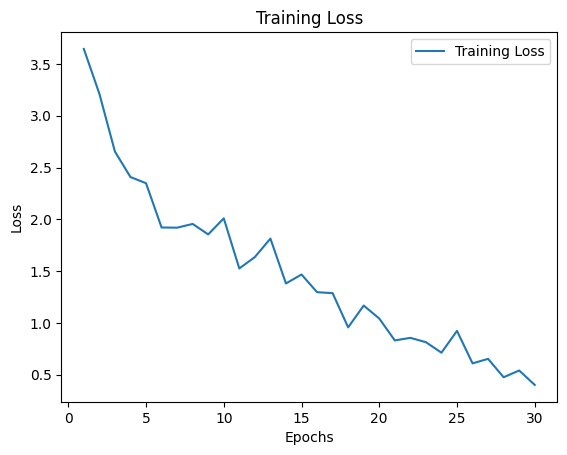

In [ ]:
model, history=train( dataset,model,
                      bs=32,epochs=30,save_every=5,
                       lr= 2e-5, warmup_steps = 5000, output_dir = "./", output_prefix = "model_skrpsi_RNx64")
plot_loss(history)

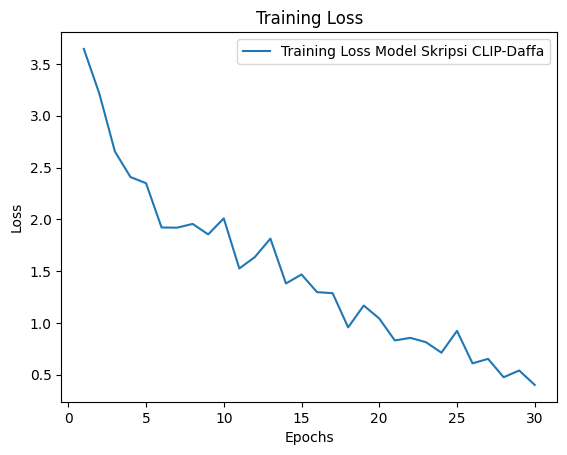

In [ ]:
plot_loss(history)

# predict

In [ ]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=40, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    #output_texts = [output_texts]
    output_texts = [output_texts[i] for i in order]
    return output_texts




In [ ]:
def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=35,  # maximum number of words
        top_p=0.8,
        temperature=1,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [ ]:
device = torch.device('cuda:0')
clip_model, preprocess = clip.load("RN50x4", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

100%|████████████████████████████████████████| 402M/402M [00:04<00:00, 103MiB/s]


In [ ]:
prefix_length = 40

model = ClipCaptionPrefix(prefix_length, clip_length=40, prefix_size=640,
                                  num_layers=8, mapping_type='transformer')
model.load_state_dict(torch.load('/content/drive/MyDrive/SKRIPSI/Hasil,Coding/Coding/model_skrpsi_RN50x4-029.pt', map_location='cpu'))

model = model.eval()
# device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)

## Dataset Predict

In [ ]:
import os
import glob
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import models
from PIL import Image
from skimage.io import imread
import cv2

import glob

# get the path/directory
folder_dir = '/content/drive/MyDrive/SKRIPSI/Gambar Test'

# iterate over files in
# that directory
for images in glob.glob(f'{folder_dir}/*'):

    # check if the image ends with png
    if (images.endswith(".jpg")):

        print(images)
        imagess = Image.open(images).convert("RGB")
        image = preprocess(imagess).unsqueeze(0).to(device)


    use_beam_search = True
    with torch.no_grad():
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix = prefix / prefix.norm(2, -1).item()
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    if use_beam_search:
        generated_text_prefix = generate_beam(model, tokenizer,embed=prefix_embed,beam_size=7,stop_token='.',entry_length=40)[0]
    else:
        generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


    print(generated_text_prefix)
    print("\n")

    with open("/content/output_caption_skripsi.txt", "a") as f:
      print(images,generated_text_prefix, file=f)


/content/drive/MyDrive/SKRIPSI/Gambar Test/gl_1062.jpg
be mindful of the parked pole in the middle of the sidewalk.


/content/drive/MyDrive/SKRIPSI/Gambar Test/gl_1060.jpg
thepassage is temporarily blocked by a car.


/content/drive/MyDrive/SKRIPSI/Gambar Test/gl_1059.jpg
the way is temporarily blocked by a motorcycle.


/content/drive/MyDrive/SKRIPSI/Gambar Test/gl_1061.jpg
the way is temporarily blocked by a motorcycle.


/content/drive/MyDrive/SKRIPSI/Gambar Test/gl_1058.jpg
there is a motorcycle blocking the way.


/content/drive/MyDrive/SKRIPSI/Gambar Test/gl_1055.jpg
witness the obstructed pathway obstructed by a parked car.


/content/drive/MyDrive/SKRIPSI/Gambar Test/gl_1056.jpg
be mindful of the parked car obstructing the way.


/content/drive/MyDrive/SKRIPSI/Gambar Test/gl_1054.jpg
be mindful of the parked car in the middle of the sidewalk.


/content/drive/MyDrive/SKRIPSI/Gambar Test/gl_1053.jpg
please watch for the parked car ahead.


/content/drive/MyDrive/SKRIPSI/Gambar 

## Single Predict

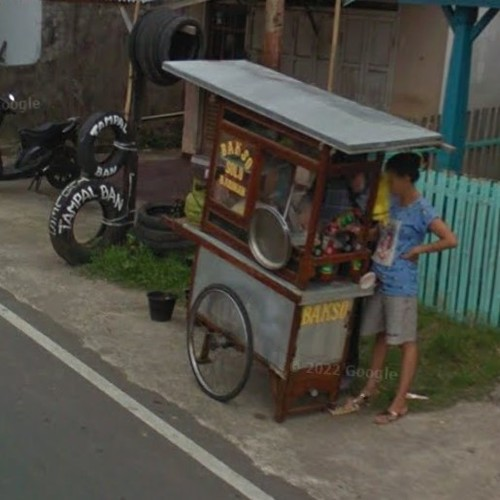

In [ ]:
images = Image.open('/content/drive/MyDrive/SKRIPSI/Gambar Test/gl_3737.jpg').convert("RGB")
image = preprocess(images).unsqueeze(0).to(device)
display(images)

In [ ]:
use_beam_search = True

# image = io.imread(UPLOADED_FILE)
# pil_image = PIL.Image.fromarray(image)
# #pil_img = Image(filename=UPLOADED_FILE)
# display(pil_image)

# image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix = prefix / prefix.norm(2, -1).item()
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer,embed=prefix_embed,beam_size=7,stop_token='.',entry_length=40)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
print('\n')
print(generated_text_prefix)



be mindful of the sales cart on the right side and be prepared to navigate around it.


## Evaluasi

In [ ]:
!git clone https://github.com/EricWWWW/image-caption-metrics.git

Cloning into 'image-caption-metrics'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 87 (delta 9), reused 1 (delta 0), pack-reused 66
Receiving objects: 100% (87/87), 93.73 MiB | 26.42 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:
cd image-caption-metrics

/content/image-caption-metrics


In [ ]:
import json

In [ ]:
import pycocoevalcap.eval as E

with open('/content/test_token_RN50x4_2.json', 'r') as f:
    gts = json.load(f)
with open('/content/output_tes_token_skripsi.json', 'r') as f:
    res = json.load(f)

meteor = E.get_meteor(gts,res)
print("score meteor yang didapatkan adalah"+ "\t" +str(meteor))

bleu = E.get_bleu(gts,res)
print("score bleu yang didapatkan adalah"+ "\t" +str(bleu))




score meteor yang didapatkan adalah	0.502059933364088
{'testlen': 5029, 'reflen': 4858, 'guess': [5029, 4649, 4269, 3889], 'correct': [4147, 3492, 2990, 2586]}
ratio: 1.0351996706461433
score bleu yang didapatkan adalah	[0.8246172201231209, 0.7870159685778834, 0.7570142255776148, 0.7328678579730313]


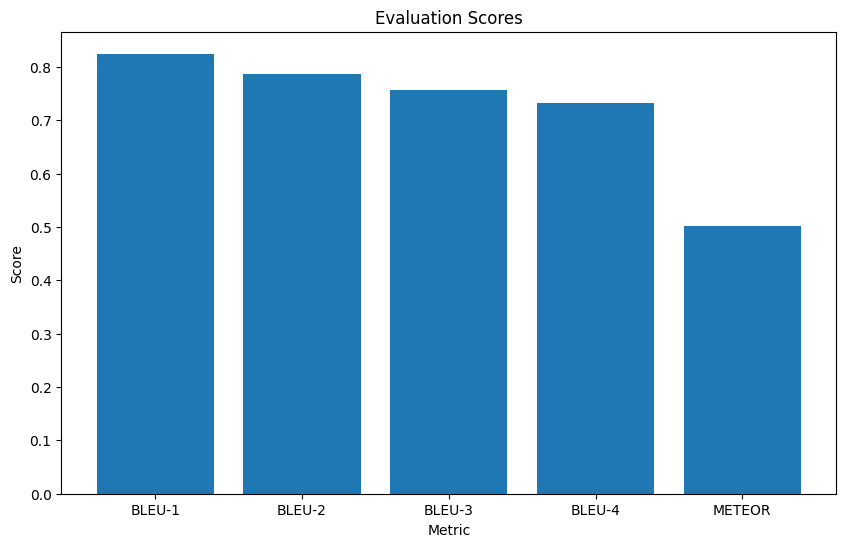

In [ ]:
import matplotlib.pyplot as plt

# Skor BLEU, METEOR, CIDEr, dan ROUGE
bleu_scores = [0.8246172201231209, 0.7870159685778834, 0.7570142255776148,  0.7328678579730313]
meteor_scores = [meteor]


# Nama metrik
metric_names = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'METEOR']

# Menambahkan skor METEOR, CIDEr, dan ROUGE ke dalam daftar skor BLEU
bleu_scores.extend([meteor_scores[0]])

# Plotting grafik
plt.figure(figsize=(10, 6))
plt.bar(metric_names, bleu_scores)

# Menambahkan label pada sumbu x dan y
plt.xlabel('Metric')
plt.ylabel('Score')

# Memberikan judul pada grafik
plt.title('Evaluation Scores')

# Menampilkan grafik
plt.show()